## <span style='color:Blue'> Web Scrapping NSE website using BeautifulSoup

The objective is to do a trending analysis of NSE Advance Decline Ratio. A sample image of what we are trying to read from NSE.

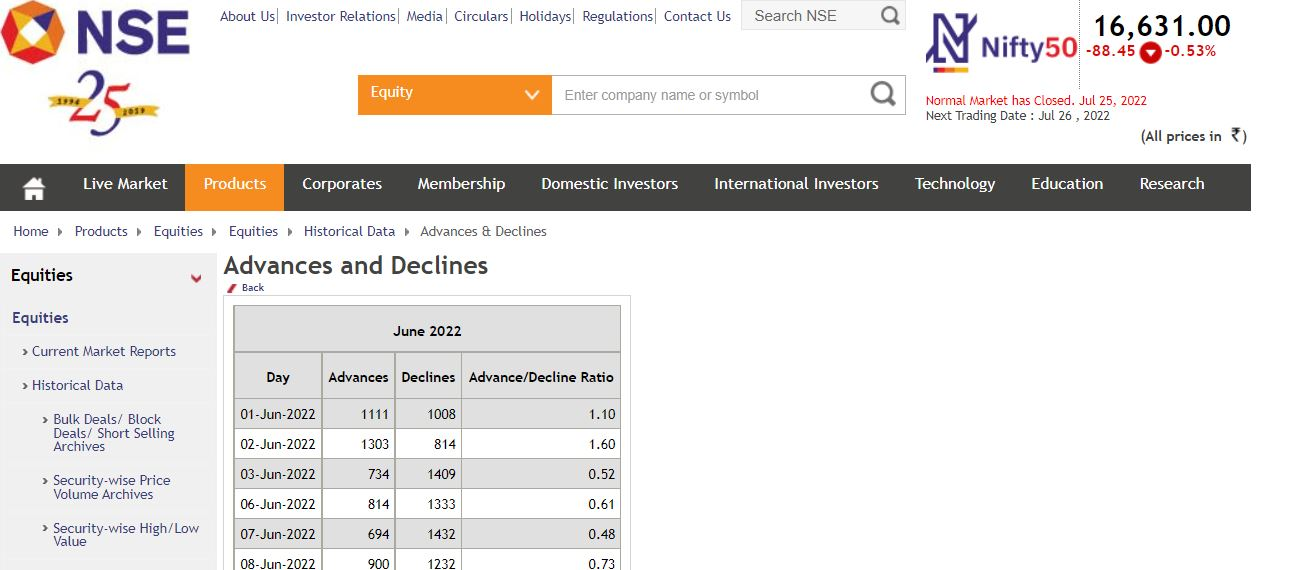




As a start upgrade pandas package to 1.4.3

In [1]:
#pip install pandas == 1.4.3


I always like ignoring warnings

In [2]:
import warnings
warnings.filterwarnings('ignore')

The user has to provide:
1. start_date
2. end_date

Based on start and end date we are going to use pandas package pd.date_range to create a date_list variable. The date_list variable will be used to create dynamic links in the for loop below

In [3]:
import datetime
import pandas as pd

start_date = datetime.datetime(2022,1,1)
end_date = datetime.datetime(2022,6,30)

date_list = pd.date_range(start_date,end_date,freq = 'M',inclusive="both").strftime("%b%Y")
date_list = date_list.str.lower()

1. Create an empty dataframe df
2. Create dynamic url using the date_list variable.
3. Use beautiful soup to parse through the HTML
4. Create 4 variable date,adv,dec,adv_dec_ratio
5. Append the ouput to empty dataframe df

In [4]:
import requests
import json
from requests.auth import HTTPBasicAuth


from bs4 import BeautifulSoup

df = pd.DataFrame()

for i in date_list:
    url = 'https://www1.nseindia.com/products/content/equities/equities/eq_advdec'+ i + '.htm'
    headers = {'User-Agent': 'Mozilla/5.0'}
    page = requests.get(url,headers=headers,auth=HTTPBasicAuth('user', 'pass'))
    soup = BeautifulSoup(page.text, 'html.parser')
    
    table = soup.find('table')
    rows = table.find_all('tr')
    
    for row in rows:
        try:
            date = row.find('td',attrs = {'class':'date'}).get_text()
            adv = int(row.find_all('td',attrs = {'class':'number'})[0].get_text())
            dec = int(row.find_all('td',attrs = {'class':'number'})[1].get_text())
            adv_dec_ratio = float(row.find_all('td',attrs = {'class':'number'})[2].get_text())
            output = pd.DataFrame([[date,adv,dec,adv_dec_ratio]],columns=['Date','Adv','Dec','Adv_Dec_Ratio'])
            df = df.append(output)
        except:
            pass



In [5]:
df.head(n=2)

,Date,Adv,Dec,Adv_Dec_Ratio
0,03-Jan-2022,1619,544,2.98
0,04-Jan-2022,1115,1013,1.10


1. Converting the date variable from format string to date
2. Adding a new variable called adv_ratio

In [6]:
df['Date'] = pd.to_datetime(df['Date'])
df['Adv_Ratio'] =df['Adv']/(df['Adv'] + df['Dec'])

In [7]:
df.head(n=2)


,Date,Adv,Dec,Adv_Dec_Ratio,Adv_Ratio
0,2022-01-03,1619,544,2.98,0.748497
0,2022-01-04,1115,1013,1.10,0.523966


Plot a simple line chart of the Adv_Ratio variable

<AxesSubplot:xlabel='Date'>

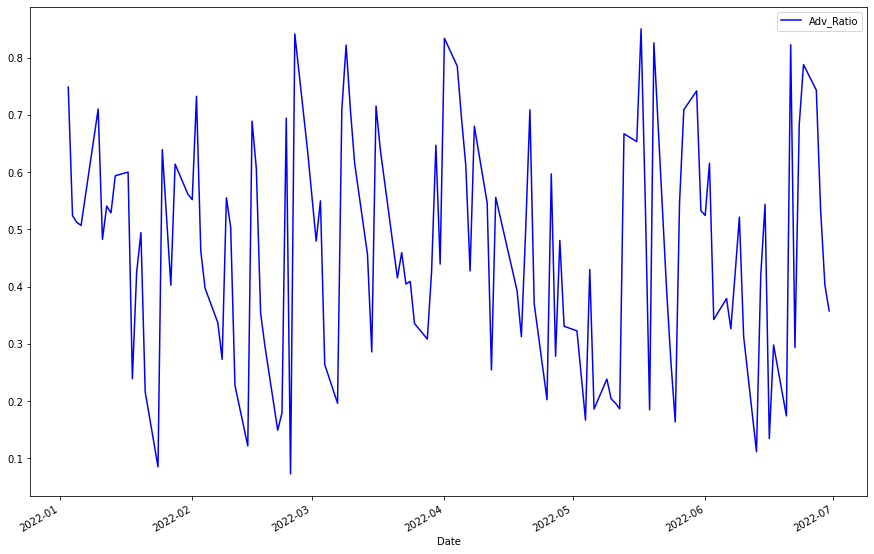

In [8]:
df.plot(x = 'Date' , y = 'Adv_Ratio' , figsize = (15,10) , color = 'blue')

The line plot does not give much information. 
Hence i proceed creating a matrix x indexed by month with column being days of the month. 
We will use matrix to create a heatmap

In [9]:
x = pd.pivot_table(df,values = 'Adv_Ratio',index = df['Date'].dt.strftime('%d') , columns = df['Date'].dt.strftime('%Y-%m'))

In [10]:
x.head(n=5)

Date,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06
Date,,,,,,
01,NaN,0.551871,NaN,0.833723,NaN,0.524304
02,NaN,0.732487,0.479458,NaN,0.322700,0.615494
03,0.748497,0.462553,0.549858,NaN,NaN,0.342510
04,0.523966,0.397332,0.263876,0.785185,0.167049,NaN
05,0.512184,NaN,NaN,0.694211,0.429706,NaN


Here is my heatmap. The whitespaces in the map are basically holidays or non trading days

Text(0.5, 1.0, 'Advance Decline HeatMap')

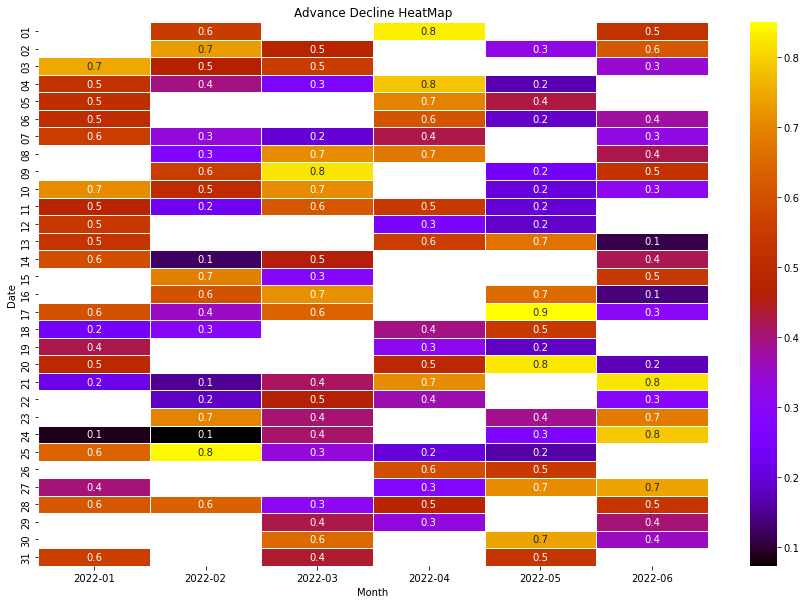

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (15,10))
sns.heatmap(x, annot = True, fmt = '.1f' ,cmap = 'gnuplot' , linewidth = 1)
plt.xlabel('Month')
plt.title('Advance Decline HeatMap')